In [3]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import warnings
import torch.nn as nn 

In [4]:
warnings.filterwarnings("ignore")

In [5]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

In [6]:
mnist = MNIST(root = 'data',
            train = True,
            download=True,
             transform = transform) 

In [7]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [8]:
def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)

Label: 5


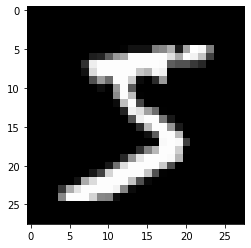

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [10]:
batch_size = 100

In [11]:
data_loader = DataLoader(mnist, batch_size = batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 1, 9, 7, 4, 7, 1, 0, 3, 0, 7, 7, 2, 0, 1, 9, 7, 0, 5, 4, 2, 5, 0, 2,
        4, 5, 7, 3, 2, 1, 7, 4, 1, 5, 2, 3, 7, 9, 7, 9, 6, 1, 3, 6, 9, 8, 6, 4,
        8, 6, 5, 3, 1, 5, 1, 7, 6, 6, 9, 8, 2, 3, 7, 6, 2, 1, 6, 6, 8, 6, 7, 6,
        8, 4, 7, 7, 4, 2, 8, 2, 2, 2, 0, 4, 2, 6, 7, 5, 7, 2, 6, 0, 0, 1, 1, 1,
        8, 4, 2, 3])


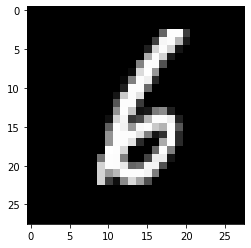

In [12]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [15]:
#Discriminator net

image_size = 784
hidden_size = 256

In [16]:
Discriminator = nn.Sequential(
                nn.Linear(image_size, hidden_size),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_size,hidden_size),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_size, 1),
                nn.Sigmoid())

In [17]:
Discriminator.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [18]:
#Generator net

latent_size = 64

In [19]:
Generator = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh())

In [20]:
y = Generator(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1,28,28)).detach())

In [21]:
gen_imgs.shape

torch.Size([2, 28, 28])

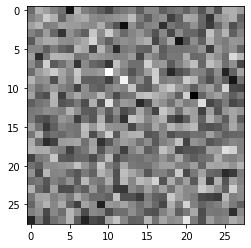

In [22]:
plt.imshow(gen_imgs[0], cmap='gray');

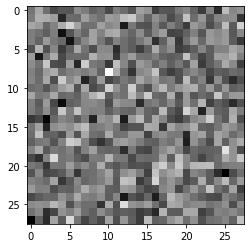

In [23]:
plt.imshow(gen_imgs[1], cmap='gray');

In [24]:
Generator.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [25]:
#Training the discriminator

loss = nn.BCELoss()
discriminator_opt = torch.optim.Adam(Discriminator.parameters(), lr=0.0002)

In [26]:
def reset_gradient():
    discriminator_opt.zero_grad()
    generator_opt.zero_grad()
    
def train_discriminator(images):
    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)
    
    outputs = Discriminator(images)
    discriminator_loss_real = loss(outputs, real_labels)
    real_score = outputs
    
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = Generator(z)
    outputs = Discriminator(fake_images)
    discriminator_loss_fake = loss(outputs, fake_labels)
    fake_score = outputs
    
    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    reset_gradient()
    discriminator_loss.backward()
    discriminator_opt.step()
    
    return discriminator_loss,real_score,fake_score
    

In [27]:
Discriminator.parameters()

<generator object Module.parameters at 0x7f36673775f0>

In [28]:
generator_opt = torch.optim.Adam(Generator.parameters(), lr=0.0002)

In [29]:
def train_generator():
    z = torch.randn(batch_size,latent_size).to(device)
    fake_images = Generator(z)
    labels = torch.ones(batch_size, 1).to(device)
    generator_loss = loss(Discriminator(fake_images), labels)
    
    reset_gradient()
    generator_loss.backward()
    generator_opt.step()
    
    return generator_loss, fake_images

In [30]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

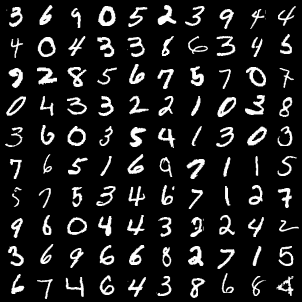

In [31]:
from IPython.display import Image
from torchvision.utils import save_image

#Save real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


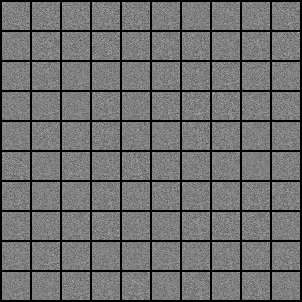

In [32]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = Generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [31]:
#Training Discriminator and Generator


num_epochs = 300
total_step = len(data_loader)
discriminator_losses, generator_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        discriminator_loss, real_score, fake_score = train_discriminator(images)
        generator_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            discriminator_losses.append(discriminator_loss.item())
            generator_losses.append(generator_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, discriminator_loss.item(), generator_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0557, g_loss: 3.9904, D(x): 0.99, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0858, g_loss: 4.9467, D(x): 0.99, D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0298, g_loss: 5.4589, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0995, g_loss: 4.6711, D(x): 0.97, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.4914, g_loss: 2.6099, D(x): 0.80, D(G(z)): 0.04
Epoch [1/300], Step [600/600], d_loss: 0.1855, g_loss: 4.8520, D(x): 0.95, D(G(z)): 0.08
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0903, g_loss: 4.9202, D(x): 0.95, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.6880, g_loss: 3.9991, D(x): 0.80, D(G(z)): 0.18
Epoch [2/300], Step [600/600], d_loss: 0.4429, g_loss: 2.9795, D(x): 0.86, D(G(z)): 0.17
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2557, g_loss: 3.8851, D(x): 0.92, D(G(z)): 0.11
Epoch [3/300], Step [400/6

In [33]:
# Save the model checkpoints 
torch.save(Generator.state_dict(), 'G.ckpt')
torch.save(Discriminator.state_dict(), 'D.ckpt')

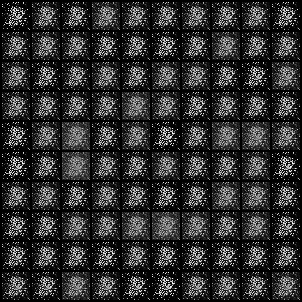

In [38]:
Image('./samples/fake_images-0001.png')

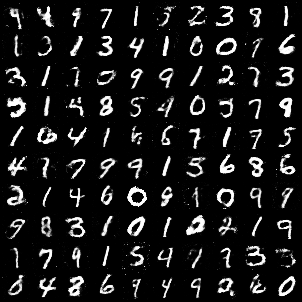

In [43]:
Image('./samples/fake_images-0300.png')